<a href="https://colab.research.google.com/github/megmarv/PsychoAI-/blob/Emotion-Identification3/Custom_CNN_HybridDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [50]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

In [51]:
DATASET_DIRECTORY = 'Augmented_Refined_Hybrid_Dataset'

image_size = (48, 48)
BATCH_SIZE = 64

train_datagen = ImageDataGenerator(rescale=1./255,)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    os.path.join(DATASET_DIRECTORY, "train"),
    target_size=image_size,
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    class_mode="categorical"
)

test_data = test_datagen.flow_from_directory(
    os.path.join(DATASET_DIRECTORY, "test"),
    target_size=image_size,
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    shuffle=False
)

# Print dataset details
print(f"Training samples: {train_data.samples}, Classes: {train_data.num_classes}")
print(f"Test samples: {test_data.samples}, Classes: {test_data.num_classes}")

Found 39193 images belonging to 7 classes.
Found 4557 images belonging to 7 classes.
Training samples: 39193, Classes: 7
Test samples: 4557, Classes: 7


In [52]:
def count_images_in_file(directory):
    counts = {}
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            counts[subdir] = sum(1 for file in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, file)))

    df = pd.DataFrame(counts, index=['Counts'])
    return df

train_count = count_images_in_file('Augmented_Refined_Hybrid_Dataset/train')
test_count = count_images_in_file('Augmented_Refined_Hybrid_Dataset/test')

print(train_count)
print(test_count)

        angry  disgust  fear  happy  neutral   sad  surprise
Counts   5599     5599  5599   5599     5599  5599      5599
        angry  disgust  fear  happy  neutral  sad  surprise
Counts    651      651   651    651      651  651       651


<Axes: >

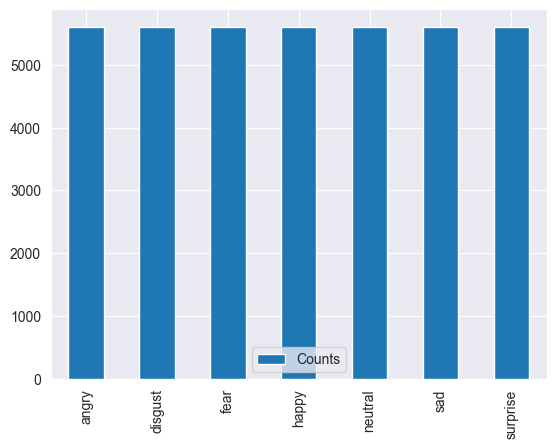

In [53]:
train_count.transpose().plot(kind='bar')

<Axes: >

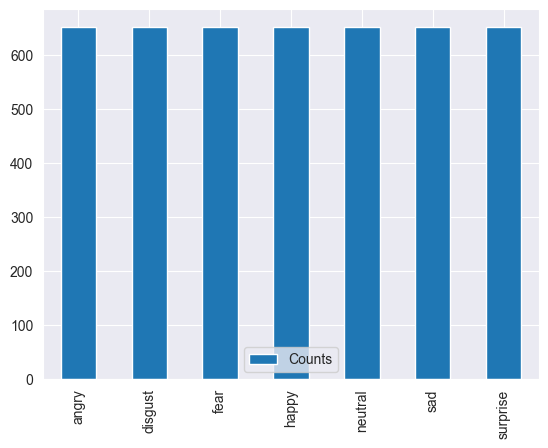

In [54]:
test_count.transpose().plot(kind='bar')

In [55]:
model = Sequential([
    Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(48,48,1)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.2),  # Added Dropout

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),  # Added Dropout
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu', padding='same'),  # Reduced from 512
    BatchNormalization(),
    Dropout(0.4),
    MaxPooling2D(2,2),

    Flatten(),

    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Reduced from 512
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Reduced from 256
    BatchNormalization(),
    Dropout(0.4),

    Dense(7, activation='softmax')
])

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

C:\Users\LENOVO\PycharmProjects\PsychoAI\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 1,587,975 (6.06 MB)

 Trainable params: 1,585,799 (6.05 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [56]:
early_stop = EarlyStopping(
    monitor='val_loss',        # Monitor the validation loss
    patience=5,                # Allow 5 epochs of no improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Monitor the validation loss
    factor=0.5,            # Reduce the learning rate by half
    patience=3,            # Wait for 3 epochs of no improvement
    min_lr=1e-6,           # Lower bound for the learning rate (1e-6)
    verbose=1              # Print a message when the learning rate is reduced
)

In [57]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

C:\Users\LENOVO\PycharmProjects\PsychoAI\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
613/613 ━━━━━━━━━━━━━━━━━━━━ 118s 187ms/step - accuracy: 0.1696 - loss: 8.8659 - val_accuracy: 0.1611 - val_loss: 8.6808 - learning_rate: 1.0000e-04
Epoch 2/30
613/613 ━━━━━━━━━━━━━━━━━━━━ 115s 188ms/step - accuracy: 0.1985 - loss: 7.5208 - val_accuracy: 0.1514 - val_loss: 7.5058 - learning_rate: 1.0000e-04
Epoch 3/30
613/613 ━━━━━━━━━━━━━━━━━━━━ 116s 189ms/step - accuracy: 0.2154 - loss: 6.4446 - val_accuracy: 0.1549 - val_loss: 6.3577 - learning_rate: 1.0000e-04
Epoch 4/30
613/613 ━━━━━━━━━━━━━━━━━━━━ 119s 194ms/step - accuracy: 0.2476 - loss: 5.4477 - val_accuracy: 0.1762 - val_loss: 5.4666 - learning_rate: 1.0000e-04
Epoch 5/30
613/613 ━━━━━━━━━━━━━━━━━━━━ 118s 193ms/step - accuracy: 0.2808 - loss: 4.5966 - val_accuracy: 0.2425 - val_loss: 4.2825 - learning_rate: 1.0000e-04
Epoch 6/30
613/613 ━━━━━━━━━━━━━━━━━━━━ 118s 193ms/step - accuracy: 0.3099 - loss: 3.9058 - val_accuracy: 0.3283 - val_loss: 3.6000 - learning_rate: 1.0000e-04
Epoch 7/30
613/613 ━━━━━━━━━━━━━━━━━━━━ 

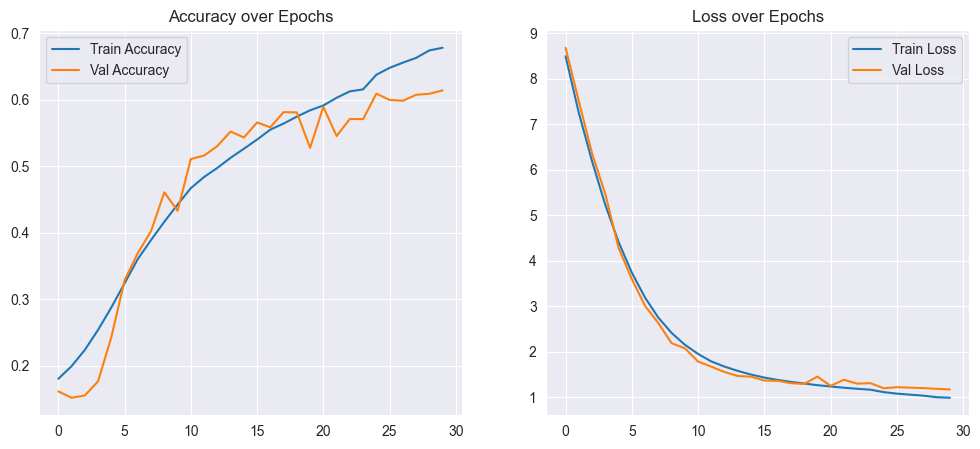

In [58]:
# Plotting Accuracy and Loss over Epochs
plt.figure(figsize=(12, 5))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss over Epochs")

plt.show()

72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step


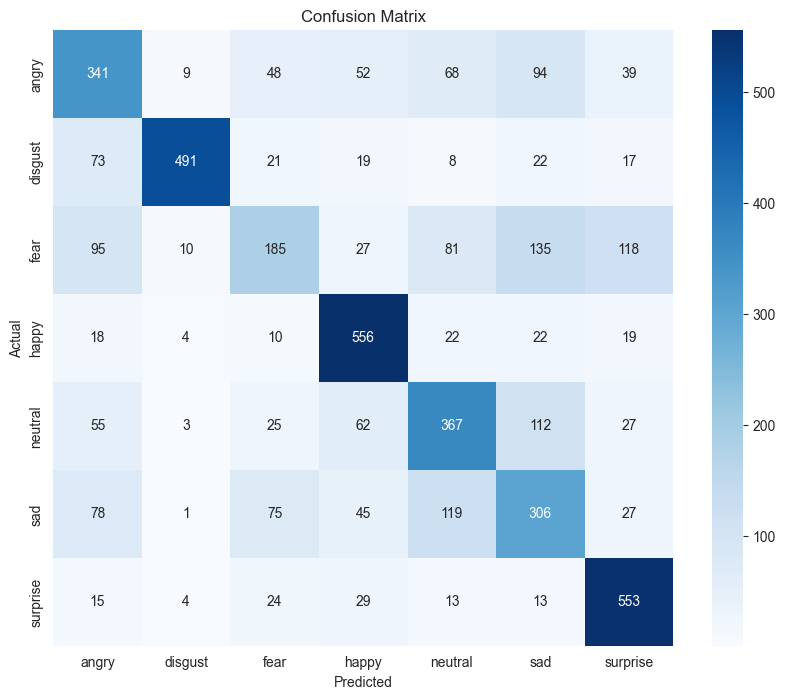

In [59]:
# Predict on validation data (test_data)
y_pred = model.predict(test_data)  # Using test_data (ImageDataGenerator for validation)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels from test_data (using the flow_from_directory)
y_true_classes = test_data.classes  # Extract true labels from the 'classes' attribute of the generator

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g',
            xticklabels=test_data.class_indices.keys(),  # Using class labels from the generator
            yticklabels=test_data.class_indices.keys())  # Using class labels from the generator
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [60]:
from sklearn.metrics import classification_report

# Get predictions
y_pred_prob = model.predict(test_data, verbose=1)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Get true labels
y_true_classes = test_data.classes  # Extract true labels
class_labels = list(test_data.class_indices.keys())  # Get class names

# Generate Classification Report
report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels)
print(report)

72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
              precision    recall  f1-score   support

       angry       0.51      0.52      0.51       651
     disgust       0.94      0.75      0.84       651
        fear       0.48      0.28      0.36       651
       happy       0.70      0.85      0.77       651
     neutral       0.54      0.56      0.55       651
         sad       0.43      0.47      0.45       651
    surprise       0.69      0.85      0.76       651

    accuracy                           0.61      4557
   macro avg       0.61      0.61      0.61      4557
weighted avg       0.61      0.61      0.61      4557



In [61]:
model.save("custom_model_30epoch.keras")

In [62]:
# Load the trained model
model = tf.keras.models.load_model("custom_model_30epoch.keras")

# Define the categories
focused_classes = ["Happy", "Neutral", "Surprise"]
unfocused_classes = ["Angry", "Disgust", "Fear", "Sad"]

# Define the image directory
image_folder = "Student_live_captures"  # Folder containing the 50 images

# Emotion class labels (update based on your dataset order)
class_labels = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

# Initialize counters
focused_count = 0
unfocused_count = 0
total_images = 0

# Process each image in the folder
for filename in os.listdir(image_folder):
    img_path = os.path.join(image_folder, filename)

    # Read and preprocess the image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
    img = cv2.resize(img, (48, 48))  # Resize to match input shape
    img = img_to_array(img) / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img)
    predicted_class = class_labels[np.argmax(prediction)]  # Get the highest probability class

    # Categorize into Focused or Unfocused
    if predicted_class in focused_classes:
        focused_count += 1
    else:
        unfocused_count += 1

    total_images += 1

# Compute the ratio
focused_ratio = focused_count / total_images
unfocused_ratio = unfocused_count / total_images

# Display results
print(f"Total Images: {total_images}")
print(f"Focused Count: {focused_count}")
print(f"Unfocused Count: {unfocused_count}")
print(f"Focused:Unfocused Ratio -> {focused_ratio:.2f} : {unfocused_ratio:.2f}")


NameError: name 'cv2' is not defined

In [ ]:
import tensorflow as tf
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model("custom_model_30epoch.keras")  # Update with your model path

# Define the image folder
image_folder = "Student_live_captures"  # Folder containing images

# Emotion class labels (update based on dataset order)
class_labels = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

# Get a list of image file names
image_files = os.listdir(image_folder)

# Choose a subset of images to display (adjust number if needed)
num_images_to_display = min(25, len(image_files))  # Display up to 25 images
selected_images = np.random.choice(image_files, num_images_to_display, replace=False)

# Set up plot grid
cols = 5  # Number of columns in the grid
rows = num_images_to_display // cols + (num_images_to_display % cols > 0)  # Auto-calculate rows

fig, axes = plt.subplots(rows, cols, figsize=(12, 10))
axes = axes.flatten()  # Flatten in case of excess subplots

# Process and display images
for i, img_name in enumerate(selected_images):
    img_path = os.path.join(image_folder, img_name)

    # Read and preprocess image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
    img_resized = cv2.resize(img, (48, 48))  # Resize to match input shape
    img_array = img_resized / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]  # Get highest probability class

    # Display image with prediction
    axes[i].imshow(img_resized, cmap="gray")
    axes[i].set_title(predicted_class, fontsize=12, color="red")
    axes[i].axis("off")  # Hide axes

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

# Show the plot
plt.tight_layout()
plt.show()